In [2]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
audio_dataset_path='/content/drive/MyDrive/archive/Data/genres_original'

In [4]:
metadata=pd.read_csv('/content/drive/MyDrive/archive/Data/features_30_sec.csv')

In [5]:
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Feature Extractor Function
Feature Extractor Function

Mel Frequency Cepstral Coefficients:

These are state-of-the-art features used in automatic speech and speech recognition studies. There are a set of steps for generation of these

features:

Since the audio signals are constantly changing, first we divide these signals into smaller frames. Each frame is around 20-40 ms long Then we try to identify different frequencies present in each frame Now, separate linguistic frequencies from the noise To discard the noise, it then takes discrete cosine transform (DCT) of these frequencies. Using DCT we keep only a specific sequence of frequencies that have a high probability of information.

In [6]:
def features_extractor(file):
  audio,sample_rate=librosa.load(file_name, res_type='kaiser_fast')
  mfccs_features=librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features=np.mean(mfccs_features.T, axis=0)

  return mfccs_scaled_features

In [7]:
metadata.drop(labels=552, axis=0, inplace=True)

In [ ]:
#Now we iterate through every audio File and extract features
#using Mel-frequency cepstral coefficients

from tqdm import tqdm
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
  try:
    final_class_labels=row["label"]
    file_name=os.path.join(os.path.abspath(audio_dataset_path),final_class_labels+'/',str(row["filename"]))
    data=features_extractor(file_name)
    extracted_features.append([data, final_class_labels])
  except Exception as e:
    print(f"Error: {e}")
    continue

479it [07:10,  1.52it/s]

In [ ]:
#converting extracted_features to pandasframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-113.59882, 121.57067, -19.162262, 42.36394, ...",blues
1,"[-207.52383, 123.98514, 8.947019, 35.86715, 2....",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686693,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855282, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues


In [ ]:
extracted_features_df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          98
Name: class, dtype: int64

Split dataset into independent and dependent dataset

In [ ]:
x=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
x.shape

(998, 40)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y= to_categorical(y_encoded)

In [ ]:
y.shape

(998, 10)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
print(x_train.shape)

print(x_test.shape)

print(y_train.shape)
print(y_test.shape)



(798, 40)
(200, 40)
(798, 10)
(200, 10)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
### No of classes
num_labels=y.shape[1]

In [ ]:
y.shape[1]

10

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
model = Sequential()

model.add(Dense(1024, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))

# Output layer with num_labels and softmax activation
model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              41984     
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
import time
t=time.localtime()
current_time=time.strftime("%H:%M:%S",t)

In [ ]:
#Training model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")  # Define current_time
checkpointer = ModelCheckpoint(filepath=f'saved_models/audio_classification_{current_time}.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()  # Start time

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start  # Calculate duration
print('Training completed in time: ', duration)



Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 4.5388 - accuracy: 0.0915
Epoch 1: val_loss improved from inf to 2.30361, saving model to saved_models/audio_classification_20240323_125139.hdf5
25/25 [==============================] - 3s 41ms/step - loss: 4.5388 - accuracy: 0.0915 - val_loss: 2.3036 - val_accuracy: 0.0750
Epoch 2/100
 4/25 [===>..........................] - ETA: 0s - loss: 2.9156 - accuracy: 0.0938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/25 [===========================>..] - ETA: 0s - loss: 2.6226 - accuracy: 0.1068
Epoch 2: val_loss improved from 2.30361 to 2.29972, saving model to saved_models/audio_classification_20240323_125139.hdf5
25/25 [==============================] - 1s 32ms/step - loss: 2.6205 - accuracy: 0.1053 - val_loss: 2.2997 - val_accuracy: 0.1100
Epoch 3/100
23/25 [==========================>...] - ETA: 0s - loss: 2.4146 - accuracy: 0.1060
Epoch 3: val_loss improved from 2.29972 to 2.29624, saving model to saved_models/audio_classification_20240323_125139.hdf5
25/25 [==============================] - 1s 31ms/step - loss: 2.4127 - accuracy: 0.1065 - val_loss: 2.2962 - val_accuracy: 0.1400
Epoch 4/100
24/25 [===========================>..] - ETA: 0s - loss: 2.3675 - accuracy: 0.1276
Epoch 4: val_loss did not improve from 2.29624
25/25 [==============================] - 1s 29ms/step - loss: 2.3614 - accuracy: 0.1303 - val_loss: 2.2984 - val_accuracy: 0.0850
Epoch 5/100
25/25 [=========================

In [ ]:
model.evaluate(x_test,y_test,verbose=0)

[2.281059980392456, 0.5450000166893005]

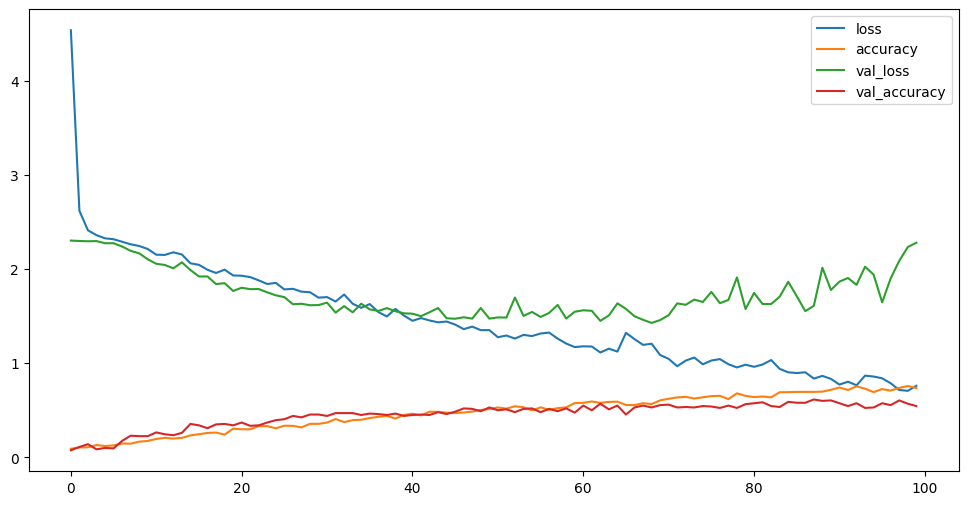

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [ ]:
# Predict probabilities for each class
predicted_probabilities = model.predict(x_test)

# Get the index of the highest probability for each sample


7/7 [==============================] - 0s 8ms/step


In [ ]:
predicted_classes = np.argmax(predicted_probabilities, axis=1)
print(predicted_classes)

[9 7 0 3 6 7 5 2 5 2 6 4 1 1 1 7 6 5 0 0 3 5 3 0 1 7 5 2 5 6 7 3 0 0 6 6 9
 5 2 7 6 0 3 9 9 8 3 2 5 6 5 5 6 5 9 2 9 2 3 6 9 8 9 9 4 2 1 3 9 1 6 9 0 9
 4 9 5 4 6 9 2 6 8 7 2 5 8 5 4 2 3 0 9 4 6 7 7 5 0 2 5 5 4 2 1 4 7 4 1 6 0
 4 3 3 6 9 4 6 3 5 4 8 5 2 2 7 1 0 0 7 5 9 5 3 1 2 5 4 9 2 9 9 0 0 9 0 3 3
 4 3 6 1 9 2 8 6 4 3 4 5 9 2 6 3 7 1 7 2 7 5 8 6 1 7 7 1 3 7 2 3 9 3 6 5 8
 2 0 6 9 7 9 6 1 2 2 9 6 2 2 1]


In [ ]:
filename = '/content/drive/MyDrive/archive/Data/genres_original/classical/classical.00000.wav'
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

predicted_probabilities = model.predict(mfccs_scaled_features)
predicted_class_index = np.argmax(predicted_probabilities, axis=1)

print("Predicted class index:", predicted_class_index)

# Assuming you have labelencoder defined earlier
predicted_class = label_encoder.inverse_transform(predicted_class_index)
print("Predicted class:", predicted_class)



1/1 [==============================] - 0s 50ms/step
Predicted class index: [1]
Predicted class: ['classical']
